In [ ]:
# Подключение библиотек
from keras.datasets import mnist, cifar10 # Mnist - набор рукописных цифр, cifar10 - изображения объектов 1-ти классов
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D, concatenate, Embedding, multiply # Базовые слои keras
from keras.layers.advanced_activations import LeakyReLU # LeakyReLU - функция активации
from keras.layers.convolutional import UpSampling2D, Conv2D # Сверточные слои keras
from keras.models import Sequential, Model # Формат модели keras
from tensorflow.keras.optimizers import Adam # Оптимизатор 

import matplotlib.pyplot as plt # Отображение графиков

import numpy as np # Numpy массивы

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_rows = 28 # Высота изображения в пикселях
img_cols = 28 # Ширина изображения в пикселях
channels = 1 # Количество каналов (глубина изображения)
img_shape = (img_rows, img_cols, channels) # Размерность входных данных для набора Mnist
latent_dim = 100 # Размерность скрытого пространства
batch_size = 128 # Размер batch_size

optimizer = Adam(0.0002, 0.5) # Оптимайзер

In [ ]:
!mkdir images # Создаем каталог 'images'

In [ ]:
def create_generator(): # Функция создания генератора
  generator = Sequential() # Инициализируем модель generator

  generator.add(Dense(256, input_dim=latent_dim)) # Добавляем Dense-слой на 256 нейронов (размерность входных данных = latent_dim)
  generator.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  generator.add(BatchNormalization(momentum=0.8)) # Добавляем слой BatchNormalization  (momentum - параметр расчета скользящего среднего и дисперсии)
  generator.add(Dense(512)) # Добавляем Dense-слой на 512 нейронов
  generator.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  generator.add(BatchNormalization(momentum=0.8)) # Добавляем слой BatchNormalization  (momentum - параметр расчета скользящего среднего и дисперсии)
  generator.add(Dense(1024)) # Добавляем Dense-слой на 1024 нейронов
  generator.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  generator.add(BatchNormalization(momentum=0.8)) # Добавляем слой BatchNormalization  (momentum - параметр расчета скользящего среднего и дисперсии)
  generator.add(Dense(np.prod(img_shape), activation='tanh')) # Добавляем Dense-слой на  img_rows*img_cols*channels нейронов с активационной функцией tanh
  generator.add(Reshape(img_shape)) # Добавляем слой Reshape (размерность выходного слоя будет (img_rows, img_cols, channels))

  noise = Input(shape=(latent_dim,)) # Создаем слой Input (Записываем входные данные рамерностью letent_dim в noise)
  img = generator(noise) # Записываем в переменную img значение, возвращаемое generator'ом  с входным параметром noise

  generator = Model(noise, img) # создаем модель generator (входные данные: noise, выходные данные: img)

  return generator # Функция возвращаем generator

In [ ]:
gen = create_generator()
gen.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         1493520   
Total params: 1,493,520
Trainable params: 1,489,936
Non-trainable params: 3,584
_________________________________________________________________


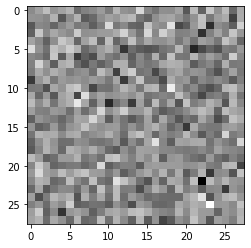

In [ ]:
input1 = np.random.random(size=(1, 100))
plt.imshow(input1, cmap='gray')
plt.axis('off')
plt.show()
predict_gen = gen.predict(input1)
plt.imshow(predict_gen[0].reshape(28, 28), cmap='gray')
plt.show()

In [ ]:
def create_discriminator(): # Функция создания дискриминатора
  discriminator = Sequential() # Инициализируем модель discriminator

  discriminator.add(Flatten(input_shape=img_shape)) # Создаем слой Flatten (размерность входных данных = (img_rows, img_cols, channels), размерность выходных данных = img_rows * img_cols * channels )
  discriminator.add(Dense(512))  # Добавляем Dense-слой на 512 нейронов
  discriminator.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  discriminator.add(Dense(256)) # Добавляем Dense-слой на 256 нейронов
  discriminator.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  discriminator.add(Dense(1, activation='sigmoid')) # Добавляем Dense-слой c 1 нейроном с активационной функцией sigmoid

  img = Input(shape=img_shape) # Создаем слой Input (записываем входные данные размерностью (img_rows, img_cols, channels) в img)
  validity = discriminator(img) # Записываем в переменную validity значение, возвращаемое discriminator'ом с входным параметром img

  discriminator = Model(img, validity) # Создаем модель discriminator (входные данные: img, выходные данные: validity)

  # Компилируем модель дискриманотра
  discriminator.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
  
  discriminator.trainable = False  # Замораживаем обучение дискриматора 

  return discriminator # Функция возвращает discriminator

In [ ]:
dis = create_discriminator()
dis.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 533505    
Total params: 533,505
Trainable params: 0
Non-trainable params: 533,505
_________________________________________________________________


In [ ]:
predict_dis = dis.predict(predict_gen)
print(predict_dis)

[[0.4937661]]


In [ ]:
batch_size = 128 # Размер batch_size

(X_train, _), (_, _) = mnist.load_data() # Загружаем в X_train изображения рукописных цифр из mnist

X_train = X_train / 127.5 - 1. # Трансофрмируем значение в диапазон от -1 до 1
X_train = np.expand_dims(X_train, axis=3) # Добавляем третью размерность для X_train ((28,28) => (28,28,1))

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
def sample_images(epoch, gen): # Функция печати изображений
  r, c = 5, 5 # Параметры вывода (количество строк (r) и количество столбцов (c))
  noise = np.random.normal(0, 1, (r * c, latent_dim)) # Создаем вектор размерностью (r*c,latent_dim (25,100)) из нормально распределенных значений
  gen_imgs = gen.predict(noise) # Предиктим картинку с помощью входной переменной gen
  
  #gen_imgs = 0.5 * gen_imgs + 0.5 # Трансформируем значения в диапазон от 0 до 1

  fig, axs = plt.subplots(r, c) # Создаем окно вывода r на c (5 на 5) ячеек
  cnt = 0 # Порядковый номер картинки
  for i in range(r): 
      for j in range(c):
          axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray') # Записываем в axs[i,j] сгенерироввнное изображение из gen_img с индексом cnt
          axs[i,j].axis('off') # Отключаем печать названия осей
          cnt += 1 # Увеличиваем индекс изображения
  plt.show() # Рисуем сгенерированные изображения
  fig.savefig("images/%d.png" % epoch) # Сохраняем изображения в папке images
  plt.close() # Завершаем работу с plt

In [ ]:
def train(generator, discriminator, epochs=30000, batch_size=128): # Функция обучения   
  
  valid = np.ones((batch_size, 1)) # Создаем массив единиц длинной batch_size
  fake = np.zeros((batch_size, 1)) # Создаем массив нулей длинной batch_size

  z = Input(shape=(latent_dim,)) # Создаем слой Input (Записываем входные данные рамерностью letent_dim в z)
  img = generator(z) # Записываем в переменную img значение, возвращаемое generator'ом  с входным параметром z
  validity = discriminator(img) # Записываем в переменную validity значение, возвращаемое discriminator'ом с входным параметром img

  combined = Model(z, validity) # Создаем полную сеть combined (входные данные: z, выходные данне: validity)
  combined.compile(loss='binary_crossentropy', optimizer=optimizer) # Компилируем сеть combined, используя в качестве функции ошибки binary_crossentropy

  sample_interval = 200 # Указываем интервал, через который будем выводить текущие сгенерированые изображения
  
  d_loss_list = [] # Массив значений ошибки дескриминатора
  g_loss_list = [] # Массив значений ошибки генератора
  d_acc_list = [] # Массив значений точности модели
  
  for epoch in range(epochs): 
    # ---------------------
    #  Train Discriminator
    # ---------------------

    idx = np.random.randint(0, X_train.shape[0], batch_size) # Создаем массив случайных значений в диапазоне от 0 до X_train.shape[0] длинной batch_size
    imgs = X_train[idx] # В переменную imgs записываем значение из X_train с индексами из idx

    noise = np.random.normal(0, 1, (batch_size, latent_dim)) # Создаем массив размерностью (batch_size,latent_dim) из нормально распределенных значений
    
    gen_imgs = generator.predict(noise) # Предиктим картинку с помощью входной переменной generator
      
    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(imgs, valid) # Получаем ошибку дискриминатора, обученного на реальной картинке (для этого передаем в функцию train_on_batch реальные изображения (imgs) и массив единици (valid))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # Получаем ошибку дискриминатора, обученного на сгенерированной картинке (для этого передаем в функцию train_on_batch сгенерирпованные изображения (gen_imgs) и массив нулей (fake))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # Получаем массив ошибок дискриминатора (поэлементно складываем массивы d_loss_real и d_loss_fake) и делим каждое значение пополам

    # ---------------------
    #  Train Generator
    # ---------------------

    g_loss = combined.train_on_batch(noise, valid) # Получаем ошибку генератора (для этого передаем в функцию train_on_batch шум (noise) и массив единиц (valid))
    
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss)) # Печатаем номер эпохи и значения ошибок на этой эпохе

    d_loss_list.append(d_loss[0]) # Добавляем в маасив значений ошибок дискриматора первое значение в массиве d_loss
    g_loss_list.append(g_loss) # Добавляем в массив значений ошибок генератора g_loss
    d_acc_list.append(100*d_loss[1]) # Добавляем в массив значений точности модели второе значение в массиве d_loss умноженное на 100
        
    # Проверяем на условие вывода информации раз в sample_interval эпох
    if ((epoch % sample_interval == 0) | (epoch == epochs-1)): 
        sample_images(epoch, generator) # Вызываем функцию sample_images для печати изображений
  
  # Выводим графики, 1 - график ошибок дискриминатора и генератора, 2 - график точности распознавания
  plt.plot(d_loss_list, label="Ошибка дискриминатора")
  plt.plot(g_loss_list, label="Ошибка генератора")
  plt.legend()
  plt.show()
  plt.plot(d_acc_list, label="Точность распознавания дискриминатора")
  plt.legend()
  plt.show()
    

0 [D loss: 0.566633, acc.: 52.34%] [G loss: 0.590679]


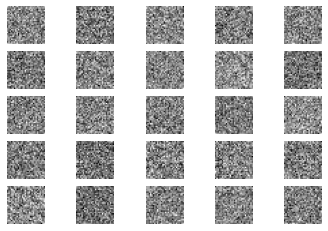

1 [D loss: 0.360489, acc.: 77.73%] [G loss: 0.608194]
2 [D loss: 0.337563, acc.: 84.38%] [G loss: 0.643417]
3 [D loss: 0.321332, acc.: 89.84%] [G loss: 0.693762]
4 [D loss: 0.313010, acc.: 90.23%] [G loss: 0.798989]
5 [D loss: 0.281017, acc.: 96.48%] [G loss: 0.959000]
6 [D loss: 0.239661, acc.: 98.05%] [G loss: 1.105223]
7 [D loss: 0.212142, acc.: 98.83%] [G loss: 1.201497]
8 [D loss: 0.190493, acc.: 99.22%] [G loss: 1.404474]
9 [D loss: 0.158868, acc.: 100.00%] [G loss: 1.571980]
10 [D loss: 0.137901, acc.: 100.00%] [G loss: 1.728294]
11 [D loss: 0.116962, acc.: 100.00%] [G loss: 1.892459]
12 [D loss: 0.103392, acc.: 100.00%] [G loss: 2.068008]
13 [D loss: 0.087521, acc.: 100.00%] [G loss: 2.201718]
14 [D loss: 0.081484, acc.: 100.00%] [G loss: 2.320910]
15 [D loss: 0.074524, acc.: 100.00%] [G loss: 2.423715]
16 [D loss: 0.069764, acc.: 100.00%] [G loss: 2.515953]
17 [D loss: 0.059735, acc.: 100.00%] [G loss: 2.673218]
18 [D loss: 0.047555, acc.: 100.00%] [G loss: 2.806062]
19 [D los

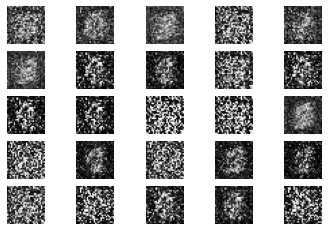

201 [D loss: 0.412417, acc.: 76.95%] [G loss: 2.422612]
202 [D loss: 0.811792, acc.: 49.61%] [G loss: 1.295618]
203 [D loss: 0.360710, acc.: 80.47%] [G loss: 2.260131]
204 [D loss: 0.544014, acc.: 68.75%] [G loss: 1.867423]
205 [D loss: 0.446430, acc.: 76.95%] [G loss: 2.168827]
206 [D loss: 0.587765, acc.: 66.41%] [G loss: 1.626714]
207 [D loss: 0.490022, acc.: 71.09%] [G loss: 2.131172]
208 [D loss: 0.613716, acc.: 66.02%] [G loss: 1.549177]
209 [D loss: 0.473572, acc.: 71.09%] [G loss: 2.005065]
210 [D loss: 0.606284, acc.: 66.80%] [G loss: 1.662889]
211 [D loss: 0.444663, acc.: 75.78%] [G loss: 2.118906]
212 [D loss: 0.670395, acc.: 58.20%] [G loss: 1.342382]
213 [D loss: 0.394928, acc.: 81.25%] [G loss: 2.164343]
214 [D loss: 0.721920, acc.: 56.25%] [G loss: 1.246990]
215 [D loss: 0.443698, acc.: 71.88%] [G loss: 2.085513]
216 [D loss: 0.698690, acc.: 56.64%] [G loss: 1.407130]
217 [D loss: 0.514781, acc.: 66.80%] [G loss: 1.733243]
218 [D loss: 0.727902, acc.: 50.00%] [G loss: 1.

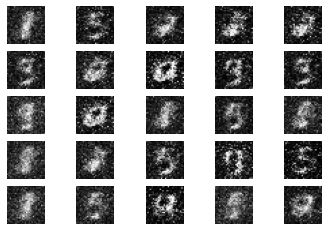

401 [D loss: 0.646131, acc.: 50.78%] [G loss: 0.671991]
402 [D loss: 0.638998, acc.: 51.17%] [G loss: 0.676822]
403 [D loss: 0.642453, acc.: 50.00%] [G loss: 0.676397]
404 [D loss: 0.651842, acc.: 49.61%] [G loss: 0.679288]
405 [D loss: 0.655228, acc.: 50.00%] [G loss: 0.681308]
406 [D loss: 0.637263, acc.: 51.17%] [G loss: 0.686472]
407 [D loss: 0.646591, acc.: 50.78%] [G loss: 0.686365]
408 [D loss: 0.652041, acc.: 51.56%] [G loss: 0.681387]
409 [D loss: 0.639026, acc.: 52.73%] [G loss: 0.675125]
410 [D loss: 0.639729, acc.: 51.17%] [G loss: 0.680961]
411 [D loss: 0.646244, acc.: 52.34%] [G loss: 0.687212]
412 [D loss: 0.650960, acc.: 52.34%] [G loss: 0.686016]
413 [D loss: 0.637758, acc.: 50.00%] [G loss: 0.676888]
414 [D loss: 0.631879, acc.: 52.73%] [G loss: 0.681189]
415 [D loss: 0.644901, acc.: 52.34%] [G loss: 0.683856]
416 [D loss: 0.644935, acc.: 52.34%] [G loss: 0.684231]
417 [D loss: 0.637656, acc.: 53.52%] [G loss: 0.690252]
418 [D loss: 0.647218, acc.: 51.56%] [G loss: 0.

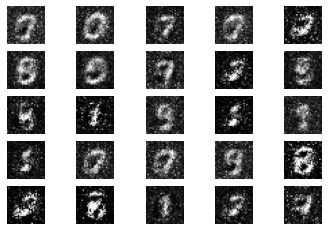

601 [D loss: 0.607076, acc.: 66.02%] [G loss: 0.785530]
602 [D loss: 0.617876, acc.: 69.14%] [G loss: 0.782008]
603 [D loss: 0.634405, acc.: 62.11%] [G loss: 0.774631]
604 [D loss: 0.622618, acc.: 64.84%] [G loss: 0.778903]
605 [D loss: 0.619987, acc.: 66.41%] [G loss: 0.774160]
606 [D loss: 0.616465, acc.: 67.19%] [G loss: 0.758877]
607 [D loss: 0.627777, acc.: 65.62%] [G loss: 0.753876]
608 [D loss: 0.623356, acc.: 65.23%] [G loss: 0.754549]
609 [D loss: 0.618076, acc.: 68.75%] [G loss: 0.756801]
610 [D loss: 0.604207, acc.: 70.31%] [G loss: 0.765778]
611 [D loss: 0.625427, acc.: 66.80%] [G loss: 0.767741]
612 [D loss: 0.630005, acc.: 70.31%] [G loss: 0.774982]
613 [D loss: 0.621203, acc.: 64.06%] [G loss: 0.786386]
614 [D loss: 0.619551, acc.: 65.62%] [G loss: 0.792158]
615 [D loss: 0.623695, acc.: 67.19%] [G loss: 0.773050]
616 [D loss: 0.618421, acc.: 71.48%] [G loss: 0.758463]
617 [D loss: 0.623613, acc.: 65.62%] [G loss: 0.760839]
618 [D loss: 0.621414, acc.: 65.23%] [G loss: 0.

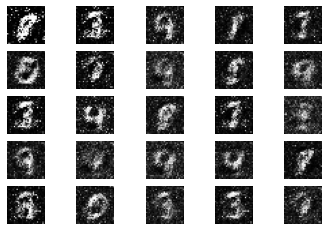

801 [D loss: 0.601909, acc.: 70.31%] [G loss: 0.852538]
802 [D loss: 0.594090, acc.: 72.27%] [G loss: 0.867526]
803 [D loss: 0.601339, acc.: 71.88%] [G loss: 0.878429]
804 [D loss: 0.594768, acc.: 71.48%] [G loss: 0.867443]
805 [D loss: 0.610168, acc.: 67.97%] [G loss: 0.839352]
806 [D loss: 0.625275, acc.: 65.23%] [G loss: 0.823886]
807 [D loss: 0.612759, acc.: 65.23%] [G loss: 0.831761]
808 [D loss: 0.608710, acc.: 67.97%] [G loss: 0.841223]
809 [D loss: 0.598275, acc.: 69.92%] [G loss: 0.849493]
810 [D loss: 0.602381, acc.: 69.92%] [G loss: 0.853431]
811 [D loss: 0.641039, acc.: 60.94%] [G loss: 0.857034]
812 [D loss: 0.607203, acc.: 69.92%] [G loss: 0.864871]
813 [D loss: 0.611683, acc.: 68.75%] [G loss: 0.896927]
814 [D loss: 0.627309, acc.: 69.92%] [G loss: 0.864689]
815 [D loss: 0.610397, acc.: 66.41%] [G loss: 0.858497]
816 [D loss: 0.637991, acc.: 64.84%] [G loss: 0.849670]
817 [D loss: 0.619551, acc.: 62.50%] [G loss: 0.863449]
818 [D loss: 0.615219, acc.: 67.58%] [G loss: 0.

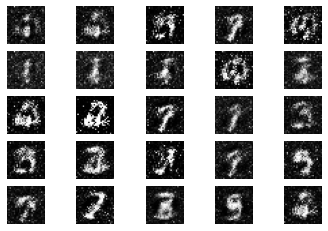

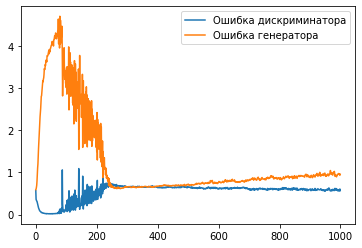

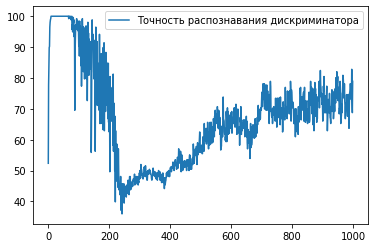

In [ ]:
generator = create_generator() # Вызываем функцию create_generator и записываем значение в переменную generator
discriminator = create_discriminator() # Вызываем функцию create_discriminator и записываем значение в переменную discriminator
train(generator, discriminator, 1000) # Вызываем функцию train с параметрами, generator, discriminator, 1000 (1000 - количество эпох)

In [ ]:
generator = create_generator() # Вызываем функцию create_generator и записываем значение в переменную generator
discriminator = create_discriminator() # Вызываем функцию create_discriminator и записываем значение в переменную discriminator
train(generator, discriminator, 30000) # Вызываем функцию train с параметрами: generator, discriminator, 30000 (30000 - количество эпох)

In [ ]:
# gen.load_weights('drive/My Drive/generator.h5')

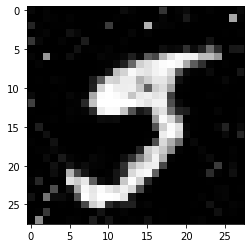

In [ ]:
input1 = np.random.random(size=(1, 100))
predict_gen = generator.predict(input1)
plt.imshow(predict_gen[0].reshape(28, 28), cmap='gray')
plt.show()

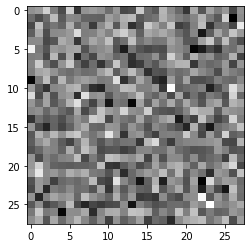

In [ ]:
# gen.load_weights('drive/My Drive/generator.h5')
predict_gen = gen.predict(input1)
plt.imshow(predict_gen[0].reshape(28, 28), cmap='gray')
plt.show()

##Свёрточный дискриминатор

https://youtu.be/GjM9vnXEdxY?t=1677


In [ ]:
def create_conv_discriminator(): # Функция создания сверточного дискрминатора
  currDisc = Sequential()  # Инициализируем модель currDisc

  currDisc.add(Conv2D(4, (3,3), padding="same", input_shape=img_shape)) # Создаем слой  Conv2D (размерность входных данных (img_shape), ядро свертки = 2, окно свертки = (3,3))
  currDisc.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  currDisc.add(Flatten()) # Добавляем слой Flatten ()
  currDisc.add(Dense(512)) # Добавляем Dense-слой на 512 нейронов
  currDisc.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  currDisc.add(Dense(1, activation='sigmoid')) # Добавляем Dense-слой c 1 нейроном с активационной функцией sigmoid

  img = Input(shape=img_shape) # Создаем слой Input (записываем входные данные размерностью (img_rows, img_cols, channels) в img)
  validity = currDisc(img) # Записываем в переменную validity значение, возвращаемое currDisc'ом с входным параметром img

  discriminator_conv = Model(img, validity) # Создаем модель discriminator_conv (входные данные: img, выходные данные: validity)

  # Компилируем модель дискриманотра
  discriminator_conv.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
 
  discriminator_conv.trainable = False  # Замораживаем обучение дискриматора 
 
  return discriminator_conv # Функция возвращает discriminator_conv

In [ ]:
generator = create_generator()
discriminator_conv = create_conv_discriminator()
train(generator, discriminator_conv, 10000)

##Слабый свёрточный дискриминатор



In [ ]:
def create_conv_small_discriminator(): # Функция создания сверточного дискрминатора
  currDisc = Sequential() # Инициализируем модель currDisc

  currDisc.add(Conv2D(8, (3,3), padding="same", input_shape=img_shape)) # Создаем слой  Conv2D (размерность входных данных (img_shape), ядро свертки = 2, окно свертки = (3,3))
  currDisc.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  currDisc.add(Flatten()) # Добавляем слой Flatten()
  currDisc.add(BatchNormalization()) # Добавляем слой BatchNormalization
  currDisc.add(Dense(1, activation='sigmoid'))  # Добавляем Dense-слой c 1 нейроном с активационной функцией sigmoid

  img = Input(shape=img_shape) # Создаем слой Input (записываем входные данные размерностью (img_rows, img_cols, channels) в img)
  validity = currDisc(img) # Записываем в переменную validity значение, возвращаемое currDisc'ом с входным параметром img

  discriminator_conv_small = Model(img, validity) # Создаем модель discriminator_conv_small (входные данные: img, выходные данные: validity)

  # Компилируем модель дискриманотра
  discriminator_conv_small.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

  discriminator_conv_small.trainable = False # Замораживаем обучение дискриматора 
  
  return discriminator_conv_small # Функция discriminator_conv_small discriminator_conv

In [ ]:
generator = create_generator()
discriminator_conv_small = create_conv_small_discriminator()
train(generator, discriminator_conv_small, 4000)

##Разные batch_size

https://youtu.be/GjM9vnXEdxY?t=1728

In [ ]:
generator = create_generator() # Вызываем функцию create_generator и записываем значение в переменную generator
discriminator_conv = create_conv_discriminator() # Вызываем функцию create_conv_discriminator и записываем значение в переменную discriminator_conv
train(generator, discriminator_conv, 10000, 32) # Вызываем функцию train с параметрами: generator, discriminator_conv, 10000, 32 (10000 - количество эпох, 32 - размер batch_size)

0 [D loss: 1.346244, acc.: 46.39%] [G loss: 0.453445]


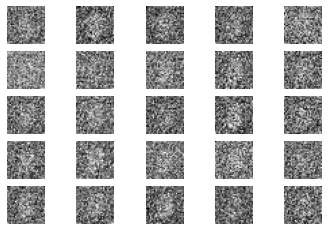

1 [D loss: 2.579154, acc.: 52.64%] [G loss: 6.481822]
2 [D loss: 0.127049, acc.: 94.53%] [G loss: 9.692171]
3 [D loss: 0.198034, acc.: 91.80%] [G loss: 9.898531]
4 [D loss: 0.109818, acc.: 95.51%] [G loss: 11.532380]
5 [D loss: 0.023777, acc.: 99.12%] [G loss: 12.912422]
6 [D loss: 0.013014, acc.: 99.71%] [G loss: 13.241568]
7 [D loss: 0.009667, acc.: 99.80%] [G loss: 13.329305]
8 [D loss: 0.019565, acc.: 99.32%] [G loss: 13.376208]
9 [D loss: 0.013732, acc.: 99.41%] [G loss: 13.638690]
10 [D loss: 0.054948, acc.: 97.66%] [G loss: 14.448988]
11 [D loss: 0.024519, acc.: 99.41%] [G loss: 14.614571]
12 [D loss: 0.019990, acc.: 99.32%] [G loss: 14.183191]
13 [D loss: 0.015520, acc.: 99.41%] [G loss: 13.580414]
14 [D loss: 0.045169, acc.: 98.44%] [G loss: 13.408134]
15 [D loss: 0.336045, acc.: 89.84%] [G loss: 19.321363]
16 [D loss: 0.225650, acc.: 91.41%] [G loss: 16.245947]
17 [D loss: 0.006564, acc.: 99.90%] [G loss: 13.488754]
18 [D loss: 0.007416, acc.: 99.90%] [G loss: 12.309091]
19 [

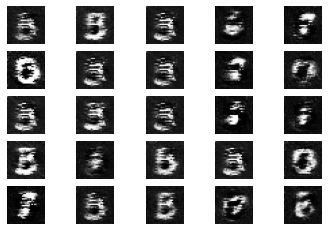

201 [D loss: 0.593575, acc.: 72.36%] [G loss: 1.240029]
202 [D loss: 0.590812, acc.: 70.70%] [G loss: 1.250594]
203 [D loss: 0.564428, acc.: 74.12%] [G loss: 1.266563]
204 [D loss: 0.559725, acc.: 74.90%] [G loss: 1.273661]
205 [D loss: 0.554468, acc.: 75.88%] [G loss: 1.292406]
206 [D loss: 0.579664, acc.: 74.22%] [G loss: 1.272543]
207 [D loss: 0.593801, acc.: 70.51%] [G loss: 1.246675]
208 [D loss: 0.622129, acc.: 68.07%] [G loss: 1.248603]
209 [D loss: 0.606578, acc.: 71.19%] [G loss: 1.259337]
210 [D loss: 0.621681, acc.: 66.70%] [G loss: 1.223236]
211 [D loss: 0.625595, acc.: 66.89%] [G loss: 1.200523]
212 [D loss: 0.624965, acc.: 69.04%] [G loss: 1.201030]
213 [D loss: 0.625307, acc.: 65.82%] [G loss: 1.244225]
214 [D loss: 0.622230, acc.: 68.16%] [G loss: 1.251038]
215 [D loss: 0.627509, acc.: 65.82%] [G loss: 1.255747]
216 [D loss: 0.590496, acc.: 73.34%] [G loss: 1.249161]
217 [D loss: 0.593786, acc.: 70.31%] [G loss: 1.263055]
218 [D loss: 0.608696, acc.: 67.97%] [G loss: 1.

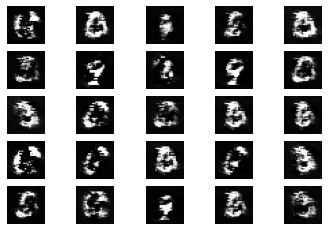

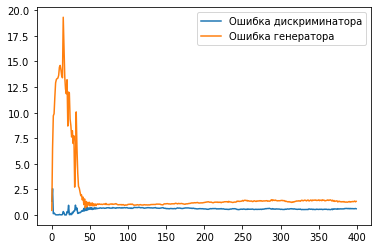

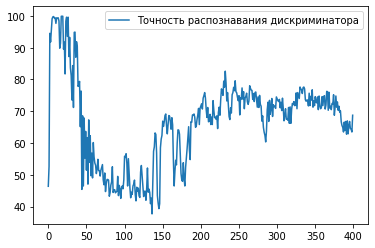

In [ ]:
generator = create_generator() # Вызываем функцию create_generator и записываем значение в переменную generator
discriminator_conv = create_conv_discriminator() # Вызываем функцию create_conv_discriminator и записываем значение в переменную discriminator_conv
train(generator, discriminator_conv, 400, 512) # Вызываем функцию train с параметрами: generator, discriminator_conv, 400, 32 (400 - количество эпох, 512 - размер batch_size)

##Сильный генератор, слабый дискриминатор

https://youtu.be/GjM9vnXEdxY?t=1795

In [ ]:
def create_max_simple_discriminator():# Функция создания дискриминатора  
  currDisc = Sequential() # Инициализируем модель currDisc

  currDisc.add(Flatten()) # Создаем слой Flatten()
  currDisc.add(Dense(1, activation='sigmoid')) # Добавляем Dense-слой c 1 нейроном с активационной функцией sigmoid

  img = Input(shape=img_shape)  # Создаем слой Input (записываем входные данные размерностью (img_rows, img_cols, channels) в img)
  validity = currDisc(img) # Записываем в переменную validity значение, возвращаемое currDisc'ом с входным параметром img

  discriminator_max_simple = Model(img, validity) # Создаем модель discriminator_max_simple (входные данные: img, выходные данные: validity)
  
  # Компилируем модель дискриманотра
  discriminator_max_simple.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

  discriminator_max_simple.trainable = False # Замораживаем обучение дискриматора 

  return discriminator_max_simple # Функция возвращает discriminator_max_simple

0 [D loss: 1.368822, acc.: 4.30%] [G loss: 0.795898]


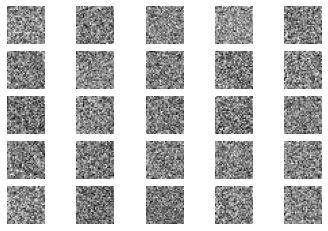

1 [D loss: 0.427608, acc.: 86.72%] [G loss: 1.537340]
2 [D loss: 0.563622, acc.: 73.44%] [G loss: 1.526323]
3 [D loss: 0.748604, acc.: 67.97%] [G loss: 1.436294]
4 [D loss: 0.713754, acc.: 69.92%] [G loss: 1.420816]
5 [D loss: 0.723857, acc.: 60.94%] [G loss: 0.940057]
6 [D loss: 0.621787, acc.: 71.09%] [G loss: 0.846844]
7 [D loss: 0.628150, acc.: 63.67%] [G loss: 0.669306]
8 [D loss: 0.693265, acc.: 62.11%] [G loss: 0.608588]
9 [D loss: 0.667983, acc.: 60.16%] [G loss: 0.566925]
10 [D loss: 0.682208, acc.: 57.42%] [G loss: 0.482442]
11 [D loss: 0.747044, acc.: 55.86%] [G loss: 0.448100]
12 [D loss: 0.694245, acc.: 55.86%] [G loss: 0.388583]
13 [D loss: 0.768438, acc.: 54.30%] [G loss: 0.371925]
14 [D loss: 0.698207, acc.: 52.73%] [G loss: 0.363200]
15 [D loss: 0.783162, acc.: 51.95%] [G loss: 0.340466]
16 [D loss: 0.731137, acc.: 52.34%] [G loss: 0.321520]
17 [D loss: 0.760927, acc.: 53.12%] [G loss: 0.350580]
18 [D loss: 0.818512, acc.: 50.39%] [G loss: 0.288302]
19 [D loss: 0.77074

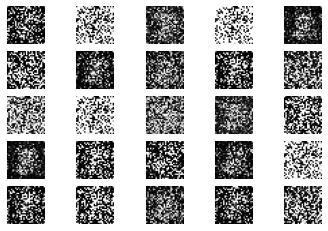

201 [D loss: 0.554047, acc.: 53.52%] [G loss: 0.511454]
202 [D loss: 0.562237, acc.: 51.17%] [G loss: 0.519281]
203 [D loss: 0.568326, acc.: 52.34%] [G loss: 0.497969]
204 [D loss: 0.554949, acc.: 53.52%] [G loss: 0.507183]
205 [D loss: 0.566344, acc.: 51.95%] [G loss: 0.510416]
206 [D loss: 0.576511, acc.: 51.17%] [G loss: 0.502630]
207 [D loss: 0.571848, acc.: 51.95%] [G loss: 0.520980]
208 [D loss: 0.572345, acc.: 51.95%] [G loss: 0.522055]
209 [D loss: 0.570307, acc.: 53.52%] [G loss: 0.502860]
210 [D loss: 0.564382, acc.: 54.30%] [G loss: 0.523789]
211 [D loss: 0.583984, acc.: 55.08%] [G loss: 0.525654]
212 [D loss: 0.573008, acc.: 54.30%] [G loss: 0.518990]
213 [D loss: 0.574504, acc.: 55.08%] [G loss: 0.520470]
214 [D loss: 0.586983, acc.: 53.52%] [G loss: 0.520686]
215 [D loss: 0.589745, acc.: 52.34%] [G loss: 0.523494]
216 [D loss: 0.599412, acc.: 51.95%] [G loss: 0.497247]
217 [D loss: 0.593532, acc.: 53.52%] [G loss: 0.506618]
218 [D loss: 0.604969, acc.: 53.12%] [G loss: 0.

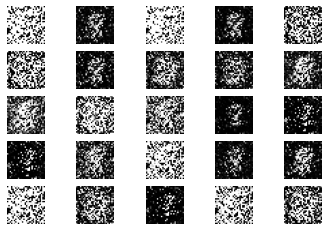

401 [D loss: 0.665314, acc.: 62.89%] [G loss: 0.542659]
402 [D loss: 0.669484, acc.: 61.33%] [G loss: 0.550954]
403 [D loss: 0.660122, acc.: 58.20%] [G loss: 0.543492]
404 [D loss: 0.650834, acc.: 60.16%] [G loss: 0.551567]
405 [D loss: 0.667651, acc.: 61.33%] [G loss: 0.539824]
406 [D loss: 0.658555, acc.: 59.77%] [G loss: 0.554358]
407 [D loss: 0.660483, acc.: 59.77%] [G loss: 0.554652]
408 [D loss: 0.661857, acc.: 60.55%] [G loss: 0.569184]
409 [D loss: 0.641415, acc.: 67.58%] [G loss: 0.557220]
410 [D loss: 0.665696, acc.: 59.77%] [G loss: 0.559638]
411 [D loss: 0.665813, acc.: 58.59%] [G loss: 0.554565]
412 [D loss: 0.660183, acc.: 60.16%] [G loss: 0.560066]
413 [D loss: 0.653614, acc.: 60.94%] [G loss: 0.554179]
414 [D loss: 0.663996, acc.: 57.03%] [G loss: 0.548598]
415 [D loss: 0.659665, acc.: 58.20%] [G loss: 0.555066]
416 [D loss: 0.672795, acc.: 55.08%] [G loss: 0.547952]
417 [D loss: 0.666305, acc.: 55.86%] [G loss: 0.549068]
418 [D loss: 0.660198, acc.: 53.12%] [G loss: 0.

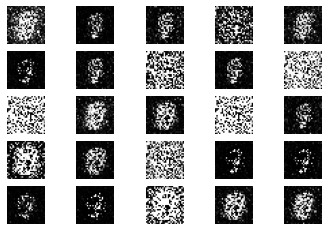

601 [D loss: 0.671623, acc.: 55.08%] [G loss: 0.602337]
602 [D loss: 0.658554, acc.: 55.86%] [G loss: 0.602131]
603 [D loss: 0.667092, acc.: 55.08%] [G loss: 0.595660]
604 [D loss: 0.667005, acc.: 58.20%] [G loss: 0.593274]
605 [D loss: 0.659072, acc.: 56.25%] [G loss: 0.596929]
606 [D loss: 0.662566, acc.: 55.08%] [G loss: 0.599204]
607 [D loss: 0.664855, acc.: 55.86%] [G loss: 0.583904]
608 [D loss: 0.664518, acc.: 56.25%] [G loss: 0.584795]
609 [D loss: 0.672255, acc.: 54.30%] [G loss: 0.583805]
610 [D loss: 0.672554, acc.: 52.34%] [G loss: 0.592868]
611 [D loss: 0.672991, acc.: 53.12%] [G loss: 0.586004]
612 [D loss: 0.673784, acc.: 51.17%] [G loss: 0.583833]
613 [D loss: 0.672555, acc.: 53.91%] [G loss: 0.589305]
614 [D loss: 0.671611, acc.: 54.69%] [G loss: 0.594972]
615 [D loss: 0.680926, acc.: 52.34%] [G loss: 0.594111]
616 [D loss: 0.669090, acc.: 54.30%] [G loss: 0.591507]
617 [D loss: 0.674228, acc.: 55.08%] [G loss: 0.588003]
618 [D loss: 0.676401, acc.: 54.69%] [G loss: 0.

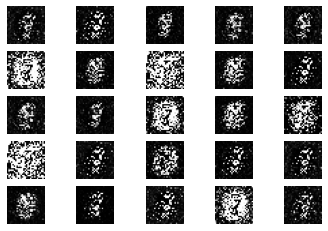

801 [D loss: 0.690823, acc.: 58.20%] [G loss: 0.631569]
802 [D loss: 0.691496, acc.: 57.81%] [G loss: 0.631027]
803 [D loss: 0.689947, acc.: 57.42%] [G loss: 0.636880]
804 [D loss: 0.686998, acc.: 57.03%] [G loss: 0.630780]
805 [D loss: 0.694668, acc.: 55.08%] [G loss: 0.637440]
806 [D loss: 0.685426, acc.: 58.20%] [G loss: 0.638444]
807 [D loss: 0.687845, acc.: 58.98%] [G loss: 0.639367]
808 [D loss: 0.687572, acc.: 57.03%] [G loss: 0.629763]
809 [D loss: 0.693103, acc.: 55.86%] [G loss: 0.636151]
810 [D loss: 0.680913, acc.: 58.59%] [G loss: 0.633017]
811 [D loss: 0.686980, acc.: 58.20%] [G loss: 0.628730]
812 [D loss: 0.689673, acc.: 56.25%] [G loss: 0.628759]
813 [D loss: 0.683853, acc.: 59.77%] [G loss: 0.631625]
814 [D loss: 0.697321, acc.: 54.30%] [G loss: 0.621310]
815 [D loss: 0.688627, acc.: 58.59%] [G loss: 0.633498]
816 [D loss: 0.695599, acc.: 56.25%] [G loss: 0.620344]
817 [D loss: 0.692097, acc.: 57.81%] [G loss: 0.620683]
818 [D loss: 0.693494, acc.: 55.47%] [G loss: 0.

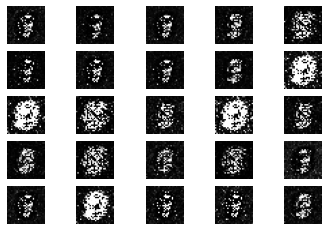

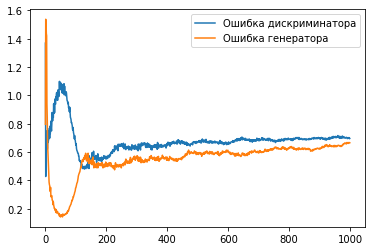

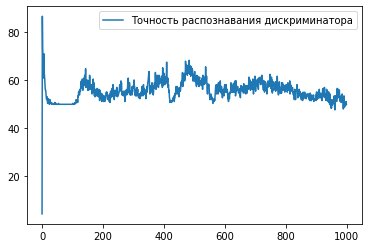

In [ ]:
generator = create_generator() # Вызываем функцию create_generator и записываем значение в переменную generator
discriminator_max_simple = create_max_simple_discriminator() # Вызываем функцию create_max_simple_discriminator и записываем значение в переменную discriminator_max_simple
train(generator, discriminator_max_simple, 1000) # Вызываем функцию train с параметрами: generator, discriminator_conv, 1000 (1000 - количество эпох)

##Слабый генератор, сильный дискриминатор

https://youtu.be/GjM9vnXEdxY?t=1838

In [ ]:
def create_max_simple_generator(): # Функция создания генератора
  currGen = Sequential() # Инициализируем модель currGen

  currGen.add(Dense(np.prod(img_shape), activation='tanh')) # Добавляем Dense-слой на  img_rows*img_cols*channels нейронов с активационной функцией tanh
  currGen.add(Reshape(img_shape)) # Добавляем слой Reshape (размерность выходного слоя будет (img_rows, img_cols, channels))

  noise = Input(shape=(latent_dim,)) # Создаем слой Input (Записываем входные данные рамерностью letent_dim в noise)
  img = currGen(noise) # Записываем в переменную img значение, возвращаемое currGen'ом  с входным параметром noise

  generator_max_simple = Model(noise, img) # создаем модель generator_max_simple (входные данные: noise, выходные данные: img)

  return generator_max_simple # Функция возвращает generator_max_simple

0 [D loss: 0.974212, acc.: 44.92%] [G loss: 1.407162]


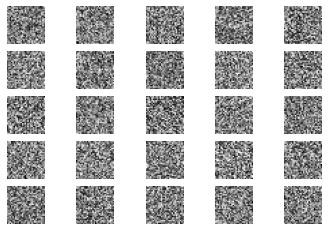

1 [D loss: 0.183433, acc.: 92.97%] [G loss: 2.876878]
2 [D loss: 0.076675, acc.: 98.44%] [G loss: 3.668589]
3 [D loss: 0.023725, acc.: 100.00%] [G loss: 4.139603]
4 [D loss: 0.032332, acc.: 100.00%] [G loss: 4.030092]
5 [D loss: 0.033848, acc.: 100.00%] [G loss: 4.122211]
6 [D loss: 0.025442, acc.: 100.00%] [G loss: 4.272493]
7 [D loss: 0.146422, acc.: 95.31%] [G loss: 3.346955]
8 [D loss: 0.108187, acc.: 95.31%] [G loss: 4.090003]
9 [D loss: 0.058951, acc.: 98.05%] [G loss: 4.640774]
10 [D loss: 0.017816, acc.: 99.61%] [G loss: 4.959161]
11 [D loss: 0.011327, acc.: 100.00%] [G loss: 4.948637]
12 [D loss: 0.016389, acc.: 99.61%] [G loss: 5.113773]
13 [D loss: 0.016492, acc.: 100.00%] [G loss: 4.810812]
14 [D loss: 0.015621, acc.: 100.00%] [G loss: 4.817605]
15 [D loss: 0.021537, acc.: 100.00%] [G loss: 4.909034]
16 [D loss: 0.010027, acc.: 100.00%] [G loss: 4.992371]
17 [D loss: 0.019057, acc.: 100.00%] [G loss: 4.621127]
18 [D loss: 0.012314, acc.: 100.00%] [G loss: 4.696478]
19 [D lo

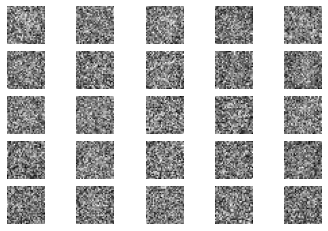

201 [D loss: 0.005129, acc.: 100.00%] [G loss: 5.912082]
202 [D loss: 0.006920, acc.: 100.00%] [G loss: 5.606567]
203 [D loss: 0.005551, acc.: 100.00%] [G loss: 5.503945]
204 [D loss: 0.005729, acc.: 100.00%] [G loss: 5.642627]
205 [D loss: 0.006488, acc.: 100.00%] [G loss: 5.615099]
206 [D loss: 0.005529, acc.: 100.00%] [G loss: 5.756099]
207 [D loss: 0.005571, acc.: 100.00%] [G loss: 5.624743]
208 [D loss: 0.005089, acc.: 100.00%] [G loss: 5.785945]
209 [D loss: 0.006793, acc.: 100.00%] [G loss: 5.536029]
210 [D loss: 0.004898, acc.: 100.00%] [G loss: 5.885351]
211 [D loss: 0.008851, acc.: 100.00%] [G loss: 5.325816]
212 [D loss: 0.006423, acc.: 100.00%] [G loss: 5.700761]
213 [D loss: 0.005540, acc.: 100.00%] [G loss: 5.810199]
214 [D loss: 0.007552, acc.: 100.00%] [G loss: 5.514598]
215 [D loss: 0.005988, acc.: 100.00%] [G loss: 5.915191]
216 [D loss: 0.004903, acc.: 100.00%] [G loss: 5.904077]
217 [D loss: 0.005997, acc.: 100.00%] [G loss: 5.716840]
218 [D loss: 0.004124, acc.: 10

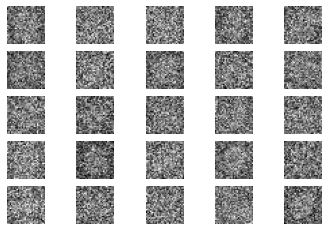

401 [D loss: 0.000991, acc.: 100.00%] [G loss: 7.116721]
402 [D loss: 0.000990, acc.: 100.00%] [G loss: 7.284955]
403 [D loss: 0.000740, acc.: 100.00%] [G loss: 7.205512]
404 [D loss: 0.000918, acc.: 100.00%] [G loss: 7.257754]
405 [D loss: 0.001025, acc.: 100.00%] [G loss: 7.178493]
406 [D loss: 0.001110, acc.: 100.00%] [G loss: 7.154418]
407 [D loss: 0.001661, acc.: 100.00%] [G loss: 6.828363]
408 [D loss: 0.001227, acc.: 100.00%] [G loss: 6.984113]
409 [D loss: 0.001246, acc.: 100.00%] [G loss: 6.937548]
410 [D loss: 0.000977, acc.: 100.00%] [G loss: 7.169456]
411 [D loss: 0.001184, acc.: 100.00%] [G loss: 7.028787]
412 [D loss: 0.000855, acc.: 100.00%] [G loss: 7.114943]
413 [D loss: 0.001054, acc.: 100.00%] [G loss: 7.088653]
414 [D loss: 0.001337, acc.: 100.00%] [G loss: 7.013279]
415 [D loss: 0.001017, acc.: 100.00%] [G loss: 7.046354]
416 [D loss: 0.001077, acc.: 100.00%] [G loss: 7.216887]
417 [D loss: 0.000772, acc.: 100.00%] [G loss: 7.267394]
418 [D loss: 0.000821, acc.: 10

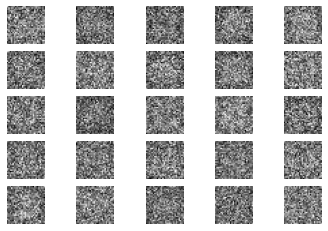

601 [D loss: 0.000469, acc.: 100.00%] [G loss: 7.729194]
602 [D loss: 0.000542, acc.: 100.00%] [G loss: 7.706160]
603 [D loss: 0.000460, acc.: 100.00%] [G loss: 7.886796]
604 [D loss: 0.000467, acc.: 100.00%] [G loss: 7.886877]
605 [D loss: 0.000487, acc.: 100.00%] [G loss: 7.927787]
606 [D loss: 0.000482, acc.: 100.00%] [G loss: 7.880005]
607 [D loss: 0.000628, acc.: 100.00%] [G loss: 7.874462]
608 [D loss: 0.000456, acc.: 100.00%] [G loss: 7.835320]
609 [D loss: 0.000518, acc.: 100.00%] [G loss: 8.036486]
610 [D loss: 0.000442, acc.: 100.00%] [G loss: 7.922441]
611 [D loss: 0.000698, acc.: 100.00%] [G loss: 7.802217]
612 [D loss: 0.000391, acc.: 100.00%] [G loss: 7.937138]
613 [D loss: 0.000464, acc.: 100.00%] [G loss: 7.867379]
614 [D loss: 0.000475, acc.: 100.00%] [G loss: 7.929098]
615 [D loss: 0.000360, acc.: 100.00%] [G loss: 7.891684]
616 [D loss: 0.000593, acc.: 100.00%] [G loss: 7.784067]
617 [D loss: 0.000360, acc.: 100.00%] [G loss: 7.985486]
618 [D loss: 0.000439, acc.: 10

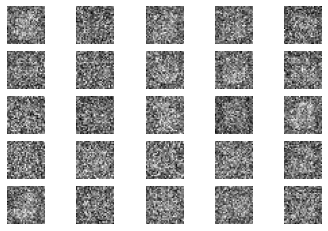

801 [D loss: 0.042079, acc.: 100.00%] [G loss: 3.022383]
802 [D loss: 0.039552, acc.: 100.00%] [G loss: 3.088522]
803 [D loss: 0.040535, acc.: 100.00%] [G loss: 3.149670]
804 [D loss: 0.047182, acc.: 100.00%] [G loss: 3.038375]
805 [D loss: 0.040257, acc.: 99.61%] [G loss: 3.192905]
806 [D loss: 0.043322, acc.: 99.61%] [G loss: 3.006567]
807 [D loss: 0.040985, acc.: 100.00%] [G loss: 3.108990]
808 [D loss: 0.042484, acc.: 99.61%] [G loss: 3.290055]
809 [D loss: 0.042122, acc.: 99.61%] [G loss: 3.108335]
810 [D loss: 0.043469, acc.: 100.00%] [G loss: 3.097988]
811 [D loss: 0.041059, acc.: 100.00%] [G loss: 3.208476]
812 [D loss: 0.041879, acc.: 100.00%] [G loss: 3.259592]
813 [D loss: 0.050048, acc.: 100.00%] [G loss: 3.151112]
814 [D loss: 0.044820, acc.: 100.00%] [G loss: 3.137858]
815 [D loss: 0.039595, acc.: 100.00%] [G loss: 3.240078]
816 [D loss: 0.043201, acc.: 100.00%] [G loss: 3.327056]
817 [D loss: 0.057601, acc.: 99.22%] [G loss: 3.161642]
818 [D loss: 0.037689, acc.: 99.61%]

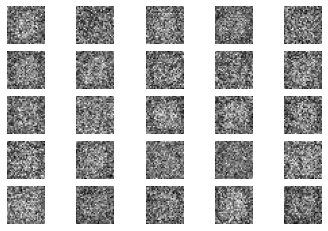

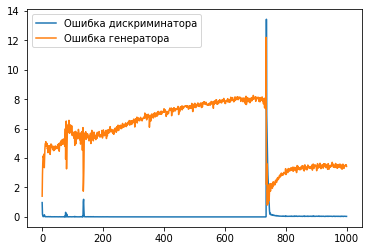

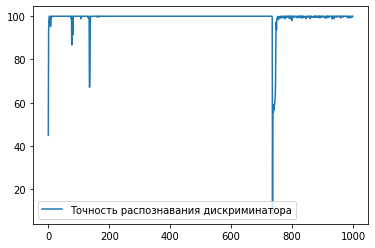

In [ ]:
generator_max_simple = create_max_simple_generator() # Вызываем функцию create_max_simple_generator и записываем значение в переменную generator_max_simple
discriminator = create_discriminator() # Вызываем функцию create_discriminator и записываем значение в переменную discriminator
train(generator_max_simple, discriminator, 1000) # Вызываем функцию train с параметрами: generator_max_simple, discriminator, 1000 (1000 - количество эпох)

##Генерация Cifar10



In [ ]:
batch_size = 128 # Размер batch_size
(X_train_cifar, _), (_, _) = cifar10.load_data() # Загружаем в X_train_cifar изображения из cifar
X_train_cifar = X_train_cifar / 127.5 - 1. # Трансофрмируем значение в диапазон от -1 до 1

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
img_rows_cifar = 32 # Высота изображения cifar в пикселях
img_cols_cifar = 32 # Ширина изображения cifar в пикселях
channels_cifar = 3 # Количество каналов (глубина изображения)
img_shape_cifar = (img_rows_cifar, img_cols_cifar, channels_cifar) # Размерность входных данных для набора cifar
latent_dim_cifar = 100 # Размерность скрытого пространства
batch_size = 128 # Размер batch_size

In [ ]:
def sample_images_cifar(epoch, gen): # Функция печати изображений
  r, c = 5, 5 # Параметры вывода (количество строк (r) и количество столбцов (c))
  noise = np.random.normal(0, 1, (r * c, latent_dim_cifar)) # Создаем вектор размерностью (r*c,latent_dim (25,100)) из нормально распределенных значений
  gen_imgs = gen.predict(noise)  # Предиктим картинку с помощью входной переменной gen

  gen_imgs = 0.5 * gen_imgs + 0.5 # Трансформируем значения в диапазон от 0 до 1

  fig, axs = plt.subplots(r, c) # Создаем окно вывода r на c (5 на 5) ячеек
  cnt = 0 # Порядковый номер картинки
  for i in range(r):
      for j in range(c):
          axs[i,j].imshow(gen_imgs[cnt, :,:,:]) # Записываем в axs[i,j] сгенерироввнное изображение из gen_img с индексом cnt
          axs[i,j].axis('off') # Отключаем печать названия осей
          cnt += 1 # Увеличиваем индекс изображения
  plt.show() # Рисуем сгенерированные изображения
  fig.savefig("images/%d.png" % epoch) # Сохраняем изображения в папке images
  plt.close() # Завершаем работу с plt

In [ ]:
def train_cifar(generator, discriminator, epochs=30000, batch_size=128): # Функция обучения   
  
  valid = np.ones((batch_size, 1)) # Создаем массив единиц длинной batch_size
  fake = np.zeros((batch_size, 1)) # Создаем массив нулей длинной batch_size
  
  z = Input(shape=(latent_dim_cifar,)) # Создаем слой Input (Записываем входные данные рамерностью letent_dim в z)
  img = generator(z) # Записываем в переменную img значение, возвращаемое generator'ом  с входным параметром z
  validity = discriminator(img) # Записываем в переменную validity значение, возвращаемое discriminator'ом с входным параметром img

  combined = Model(z, validity) # Создаем полную сеть combined (входные данные: z, выходные данне: validity)
  combined.compile(loss='binary_crossentropy', optimizer=optimizer) # Компилируем сеть combined, используя в качестве функции ошибки binary_crossentropy

  sample_interval = 200 # Указываем интервал, через который будем текущие сгенерированые изображения
  
  d_loss_list = [] # Массив значений ошибки дескриминатора
  g_loss_list = [] # Массив значений ошибки генератора
  d_acc_list = [] # Массив значений точности модели
  
  for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    idx = np.random.randint(0, X_train_cifar.shape[0], batch_size) # Создаем массив случайных значений в диапазоне от 0 до X_train_cifar.shape[0] длинной batch_size
    imgs = X_train_cifar[idx] # В переменную imgs записываем значение из X_train_cifar с индексами из idx

    noise = np.random.normal(0, 1, (batch_size, latent_dim_cifar)) # Создаем массив размерностью (batch_size,latent_dim_cifar) из нормально распределенных значений

    gen_imgs = generator.predict(noise) # Предиктим картинку с помощью входной переменной generator
   
    d_loss_real = discriminator.train_on_batch(imgs, valid) # Получаем ошибку дискриминатора, обученного на реальной картинке (для этого передаем в функцию train_on_batch реальные изображения (imgs) и массив единици (valid))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # Получаем ошибку дискриминатора, обученного на сгенерированной картинке (для этого передаем в функцию train_on_batch сгенерирпованные изображения (gen_imgs) и массив нулей (fake))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # Получаем массив ошибок дискриминатора (поэлементно складываем массивы d_loss_real и d_loss_fake) и делим каждое значение пополам 

    # ---------------------
    #  Train Generator
    # ---------------------

    noise = np.random.normal(0, 1, (batch_size, latent_dim_cifar)) # Создаем массив размерностью (batch_size,latent_dim_cifar) из нормально распределенных значений

    g_loss = combined.train_on_batch(noise, valid) # Получаем ошибку генератора (для этого передаем в функцию train_on_batch шум (noise) и массив единиц (valid))

    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss)) # Печатаем номер эпохи и значения ошибок на этой эпохе

    d_loss_list.append(d_loss[0]) # Добавляем в маасив значений ошибок дискриматора первое значение в массиве d_loss
    g_loss_list.append(g_loss) # Добавляем в массив значений ошибок генератора g_loss
    d_acc_list.append(100*d_loss[1]) # Добавляем в массив значений точности модели второе значение в массиве d_loss умноженное на 100
    
    # Проверяем на условие вывода информации раз в sample_interval эпох
    if ((epoch % sample_interval == 0) | (epoch == epochs-1)):
        sample_images_cifar(epoch, generator)

  # Выводим графики, 1 - график ошибок дискриминатора и генератора, 2 - график точности распознавания   
  plt.plot(d_loss_list, label="Ошибка дискриминатора")
  plt.plot(g_loss_list, label="Ошибка генератора")
  plt.legend()
  plt.show()
  plt.plot(d_acc_list, label="Точность распознавания дискриминатора")
  plt.legend()
  plt.show()
    

In [ ]:
currGen = Sequential() # Инициализируем модель currGen

currGen.add(Dense(256, input_dim=latent_dim))  # Добавляем Dense-слой на 256 нейронов (размерность входных данных = latent_dim)
currGen.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
currGen.add(BatchNormalization(momentum=0.8)) # Добавляем слой BatchNormalization  (momentum - параметр расчета скользящего среднего и дисперсии)
currGen.add(Dense(512)) # Добавляем Dense-слой на 512 нейронов
currGen.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
currGen.add(BatchNormalization(momentum=0.8)) # Добавляем слой BatchNormalization  (momentum - параметр расчета скользящего среднего и дисперсии)
currGen.add(Dense(1024)) # Добавляем Dense-слой на 1024 нейронов
currGen.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
currGen.add(BatchNormalization(momentum=0.8)) # Добавляем слой BatchNormalization  (momentum - параметр расчета скользящего среднего и дисперсии)
currGen.add(Dense(np.prod(img_shape_cifar), activation='tanh')) # Добавляем Dense-слой на  img_rows*img_cols*channels нейронов с активационной функцией tanh
currGen.add(Reshape(img_shape_cifar)) # Добавляем слой Reshape (размерность выходного слоя будет (img_rows_cifar, img_cols_cifar, channels_cifar))

noise = Input(shape=(latent_dim,)) # Создаем слой Input (Записываем входные данные рамерностью letent_dim в noise)
img = currGen(noise) # Записываем в переменную img значение, возвращаемое generator'ом  с входным параметром noise

generator_cifar = Model(noise, img) # создаем модель generator_cifar (входные данные: noise, выходные данные: img)

In [ ]:
currDisc = Sequential() # Инициализируем модель currDisc

currDisc.add(Flatten(input_shape=img_shape_cifar)) # Создаем слой Flatten (размерность входных данных = (img_rows_cifar, img_cols_cifar, channels_cifar), размерность выходных данных = img_rows_cifar * img_cols *_cifar * channels )
currDisc.add(Dense(512)) # Добавляем Dense-слой на 512 нейронов
currDisc.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
currDisc.add(Dense(256)) # Добавляем Dense-слой на 256 нейронов
currDisc.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
currDisc.add(Dense(1, activation='sigmoid')) # Добавляем Dense-слой c 1 нейроном с активационной функцией sigmoid

img = Input(shape=img_shape_cifar) # Создаем слой Input (записываем входные данные размерностью (img_rows_cifar, img_cols_cifar, channels_cifar) в img)
validity = currDisc(img) # Записываем в переменную validity значение, возвращаемое currDisc'ом с входным параметром img

discriminator_cifar = Model(img, validity) # Создаем модель discriminator_cifar (входные данные: img, выходные данные: validity)

 # Компилируем модель дискриманотра
discriminator_cifar.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

discriminator_cifar.trainable = False # Замораживаем обучение дискриматора 

In [ ]:
train_cifar(generator_cifar, discriminator_cifar, 8000) # Вызываем функцию train_cifar с параметрами: generator_cifar, discriminator_cifar, 8000 (8000 - количество эпох)

##CGAN - GAN с условием

https://youtu.be/GjM9vnXEdxY?t=1912



In [ ]:
num_classes = 10 # Количество классов изображений

In [ ]:
def create_conditional_generator(): # Функция создания генератора
  generator = Sequential() # Инициализируем модель generator

  generator.add(Dense(256, input_dim=latent_dim)) # Добавляем Dense-слой на 256 нейронов (размерность входных данных = latent_dim)
  generator.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  generator.add(BatchNormalization(momentum=0.8)) # Добавляем слой BatchNormalization  (momentum - параметр расчета скользящего среднего и дисперсии)
  generator.add(Dense(512)) # Добавляем Dense-слой на 512 нейронов
  generator.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  generator.add(BatchNormalization(momentum=0.8)) # Добавляем слой BatchNormalization  (momentum - параметр расчета скользящего среднего и дисперсии)
  generator.add(Dense(1024)) # Добавляем Dense-слой на 1024 нейронов
  generator.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  generator.add(BatchNormalization(momentum=0.8)) # Добавляем слой BatchNormalization  (momentum - параметр расчета скользящего среднего и дисперсии)
  generator.add(Dense(np.prod(img_shape), activation='tanh')) # Добавляем Dense-слой на  img_rows*img_cols*channels нейронов с активационной функцией tanh
  generator.add(Reshape(img_shape)) # Добавляем слой Reshape (размерность выходного слоя будет (img_rows, img_cols, channels))

  noise = Input(shape=(latent_dim,))  # Создаем слой Input (Записываем входные данные рамерностью letent_dim в noise)
  label = Input(shape=(1,), dtype='int32') # Создаем слой Input (Записываем входные данные рамерностью (1) в label)
  label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label)) # Создаем слой Flatten() от слоя Embedding с входными параметрами num_classes и latent_dim

  model_input = multiply([noise, label_embedding]) # Объединяем слои noise и label_embedding с помощью multiply
  img = generator(model_input)  # Записываем в переменную img значение, возвращаемое generator'ом  с входным параметром model_input

  generator = Model([noise, label], img) # создаем модель generator (входные данные: noise и label, выходные данные: img)
  
  return generator # Функция возвращаем generator

In [ ]:
def create_conditional_discriminator(): # Функция создания дискриминатора
  discriminator = Sequential() # Инициализируем модель discriminator

  discriminator.add(Flatten()) # Создаем слой Flatten (размерность входных данных = (img_rows, img_cols, channels), размерность выходных данных = img_rows * img_cols * channels )
  discriminator.add(Dense(512)) # Добавляем Dense-слой на 512 нейронов
  discriminator.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  discriminator.add(Dense(256)) # Добавляем Dense-слой на 256 нейронов
  discriminator.add(LeakyReLU(alpha=0.2)) # Добавляем слой активационной функции с параметром 0.2
  discriminator.add(Dense(1, activation='sigmoid')) # Добавляем Dense-слой c 1 нейроном с активационной функцией sigmoid
  
  img = Input(shape=img_shape) # Создаем слой Input (записываем входные данные размерностью (img_rows, img_cols, channels) в img)
  label = Input(shape=(1,), dtype='int32') # Создаем слой Input (Записываем входные данные рамерностью (1) в label)

  label_embedding = Flatten()(Embedding(num_classes, np.prod(img_shape))(label)) # Создаем слой Flatten() от слоя Embedding с входными параметрами num_classes и (img_rows * img_cols * channels)
  flat_img = Flatten()(img) # Создаем слой Flatten() от слоя img

  model_input = multiply([flat_img, label_embedding])  # Объединяем слои flat_img и label_embedding с помощью multiply 

  validity = discriminator(model_input)  # Записываем в переменную validity значение, возвращаемое discriminator'ом с входным параметром model_input

  discriminator = Model([img, label], validity) # Создаем модель discriminator (входные данные: img, выходные данные: validity)

  # Компилируем модель дискриманотра
  discriminator.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

  discriminator.trainable = False # Замораживаем обучение дискриматора

  return discriminator # Функция возвращает discriminator

In [ ]:
def sample_images_conditional(epoch, gen):  # Функция печати изображений
  r, c = 2, 5 # Параметры вывода (количество строк (r) и количество столбцов (c))
  noise = np.random.normal(0, 1, (r * c, latent_dim)) # Создаем вектор размерностью (r*c,latent_dim (10,100)) из нормально распределенных значений
  sampled_labels = np.arange(0, 10).reshape(-1, 1) # Создаем массив мток от 0 до 10 и решейпим его в размерность (10, 1)
  
  gen_imgs = gen.predict([noise, sampled_labels]) # Предиктим картинку с помощью входной переменной gen

  gen_imgs = 0.5 * gen_imgs + 0.5 # Трансформируем значения в диапазон от 0 до 1

  fig, axs = plt.subplots(r, c) # Создаем окно вывода r на c (2 на 5) ячеек
  cnt = 0 # Порядковый номер картинки
  for i in range(r):
      for j in range(c):
          axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray') # Записываем в axs[i,j] сгенерироввнное изображение из gen_img с индексом cnt
          axs[i,j].axis('off') # Отключаем печать названия осей
          cnt += 1 # Увеличиваем индекс изображения
  plt.show()  # Рисуем сгенерированные изображения
  fig.savefig("images/%d.png" % epoch) # Сохраняем изображения в папке images
  plt.close()# Завершаем работу с plt 

In [ ]:
batch_size = 128 # Размер batch_size

(X_train, y_train), (_, _) = mnist.load_data()  # Загружаем в X_train изображения рукописных цифр из mnist, в y_train соответсвующие номера классов

X_train = (X_train.astype(np.float32) - 127.5) / 127.5 # Трансофрмируем значение в диапазон от -1 до 1
X_train = np.expand_dims(X_train, axis=3)  # Добавляем третью размерность для X_train ((28,28) => (28,28,1))
y_train = y_train.reshape(-1, 1)  # решейпим y_train его в размерность (60000, 1)

In [ ]:
def train_conditional(generator, discriminator, epochs=30000, batch_size=128): # Функция обучения
  
  valid = np.ones((batch_size, 1)) # Создаем массив единиц длинной batch_size
  fake = np.zeros((batch_size, 1)) # Создаем массив нулей длинной batch_size
  
  noise = Input(shape=(latent_dim,)) # Создаем слой Input (Записываем входные данные рамерностью letent_dim в noise)
  label = Input(shape=(1,)) # Создаем слой Input (Записываем входные данные рамерностью (1) в label)
  img = generator([noise, label]) # Записываем в переменную img значение, возвращаемое generator'ом  с входными параметрами noise и label
  
  val = discriminator([img, label]) # Записываем в переменную val значение, возвращаемое discriminator'ом с входными параметрами img и label
  
  combined = Model([noise, label], val) # Создаем полную сеть combined (входные данные: noise и label, выходные данне: val)
  combined.compile(loss=['binary_crossentropy'], optimizer=optimizer) # Компилируем сеть combined, используя в качестве функции ошибки binary_crossentropy
  
  sample_interval = 200 # Указываем интервал, через который будем текущие сгенерированые изображения
  
  d_loss_list = [] # Массив значений ошибки дескриминатора
  g_loss_list = [] # Массив значений ошибки генератора
  d_acc_list = [] # Массив значений точности модели
  
  for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    idx = np.random.randint(0, X_train.shape[0], batch_size) # Создаем массив случайных значений в диапазоне от 0 до X_train.shape[0] длинной batch_size
    imgs, labels = X_train[idx], y_train[idx]  # В переменную imgs записываем значение из X_train с индексами из idx, в переменную labels записываем значения из y_train с индексами из idx

    noise = np.random.normal(0, 1, (batch_size, latent_dim)) # Создаем массив размерностью (batch_size,latent_dim) из нормально распределенных значений 

    gen_imgs = generator.predict([noise, labels]) # Предиктим картинку с помощью входной переменной generator
    
    # Train the discriminator
    d_loss_real = discriminator.train_on_batch([imgs, labels], valid) # Получаем ошибку дискриминатора, обученного на реальной картинке (для этого передаем в функцию train_on_batch реальные изображения (imgs), метки (labels) и массив единици (valid)) 
    d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake) # Получаем ошибку дискриминатора, обученного на сгенерированной картинке (для этого передаем в функцию train_on_batch сгенерирпованные изображения (gen_imgs), метки (labels) и массив нулей (fake))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # Получаем массив ошибок дискриминатора (поэлементно складываем массивы d_loss_real и d_loss_fake) и делим каждое значение пополам

    # ---------------------
    #  Train Generator
    # ---------------------

    sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1) # Получаем массив случайных меток от 0 до 10 размерностью batch_size и решейпим его в размерность (batch_size, 1)
    
    g_loss = combined.train_on_batch([noise, sampled_labels], valid) # Получаем ошибку генератора (для этого передаем в функцию train_on_batch шум (noise), метки (sampled_labels) и массив единиц (valid))

    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss)) # Печатаем номер эпохи и значения ошибок на этой эпохе

    d_loss_list.append(d_loss[0]) # Добавляем в маасив значений ошибок дискриматора первое значение в массиве d_loss
    g_loss_list.append(g_loss) # Добавляем в массив значений ошибок генератора g_loss
    d_acc_list.append(100*d_loss[1]) # Добавляем в массив значений точности модели второе значение в массиве d_loss умноженное на 100
    
    # Проверяем на условие вывода информации раз в sample_interval эпох
    if ((epoch % sample_interval == 0) | (epoch == epochs-1)):
        sample_images_conditional(epoch, generator)
        
  # Выводим графики, 1 - график ошибок дискриминатора и генератора, 2 - график точности распознавания
  plt.plot(d_loss_list, label="Ошибка дискриминатора")
  plt.plot(g_loss_list, label="Ошибка генератора")
  plt.legend()
  plt.show()
  plt.plot(d_acc_list, label="Точность распознавания дискриминатора")
  plt.legend()
  plt.show()
    

In [ ]:
conditional_generator = create_conditional_generator() # Вызываем функцию create_conditional_generator и записываем значение в переменную conditional_generator
conditional_discriminator = create_conditional_discriminator() # Вызываем функцию create_conditional_discriminator и записываем значение в переменную conditional_discriminator

In [ ]:
train_conditional(conditional_generator, conditional_discriminator, 20000) # Вызываем функцию train_conditional с параметрами: conditional_generator, conditional_discriminator, 20000 (20000 - количество эпох)